# Customer Churn Prediction


The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

In [1]:
# Common libraries for data analysis
import numpy as np
import pandas as pd

# Libraries for graphs
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, mutual_info_score, recall_score, accuracy_score, precision_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
data=pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [3]:
data.shape

(7043, 21)

In [4]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
for col in data:
    print(col, ":" ,data[col].unique())

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank tr

In [6]:
data['customerID'].nunique()

7043

In [7]:
data_df = data.loc[data['TotalCharges']!=' ']

In [8]:
# remove the customer ID
data_df=data_df.drop(['customerID'],axis=1)

# convert TotalCharges to float
data_df = data_df.astype({"TotalCharges": float})

In [9]:
# check for other missing value percentage
(data_df.isnull().sum() / len(data_df)).sort_values(ascending=False) * 100

gender              0.0
SeniorCitizen       0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Contract            0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineBackup        0.0
OnlineSecurity      0.0
InternetService     0.0
MultipleLines       0.0
PhoneService        0.0
tenure              0.0
Dependents          0.0
Partner             0.0
Churn               0.0
dtype: float64

## Exploratory Data Analysis

Value counts of Churn Churn
No     5174
Yes    1869
Name: count, dtype: int64


Text(0.5, 1.0, 'Churn of Customers')

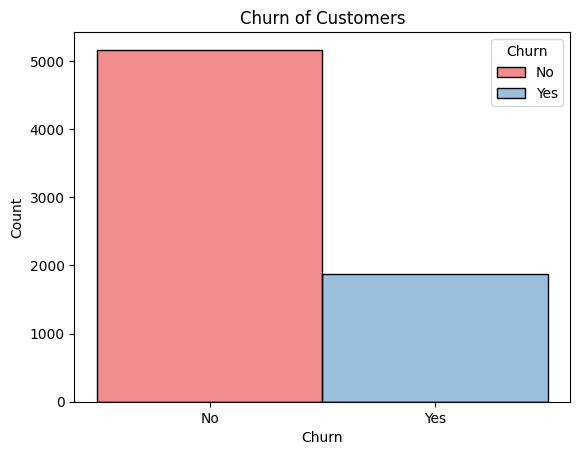

In [10]:
print("Value counts of Churn", data['Churn'].value_counts())
sns.histplot(data=data_df, x="Churn", hue="Churn", palette = "Set1")
plt.title('Churn of Customers')

<Axes: xlabel='gender', ylabel='Count'>

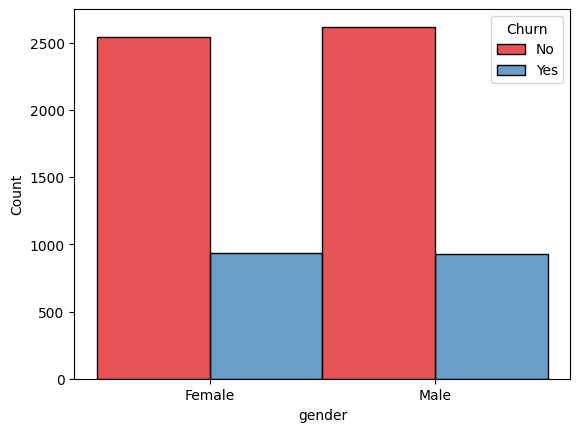

In [11]:
#sns.histplot(data=data, x="gender", hue="Churn")

sns.histplot(binwidth=1,
            x='gender',
            hue='Churn',
            data=data_df,
            stat="count",
            multiple="dodge", palette = "Set1")

In [12]:
data_df['gender'].value_counts()

gender
Male      3549
Female    3483
Name: count, dtype: int64

<Axes: xlabel='tenure', ylabel='TotalCharges'>

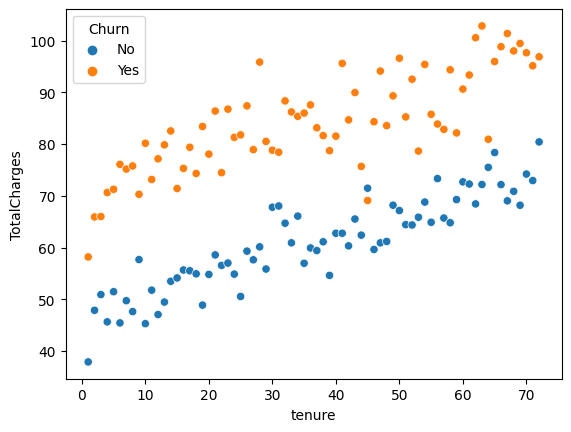

In [13]:
ave_tot_ch=data_df.groupby(['tenure', 'Churn'])['MonthlyCharges'].mean().reset_index(name='TotalCharges')
sns.scatterplot(data=ave_tot_ch, x= 'tenure', y='TotalCharges', hue='Churn')

<Axes: xlabel='tenure', ylabel='AverageMonthlyCharges'>

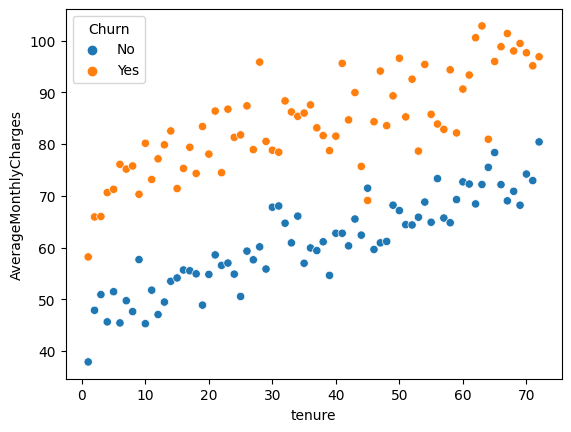

In [14]:
ave_monthly_ch=data_df.groupby(['tenure', 'Churn'])['MonthlyCharges'].mean().reset_index(name='AverageMonthlyCharges')
sns.scatterplot(data=ave_monthly_ch, x= 'tenure', y='AverageMonthlyCharges', hue='Churn')

<Axes: xlabel='tenure', ylabel='AverageMonthlyCharges'>

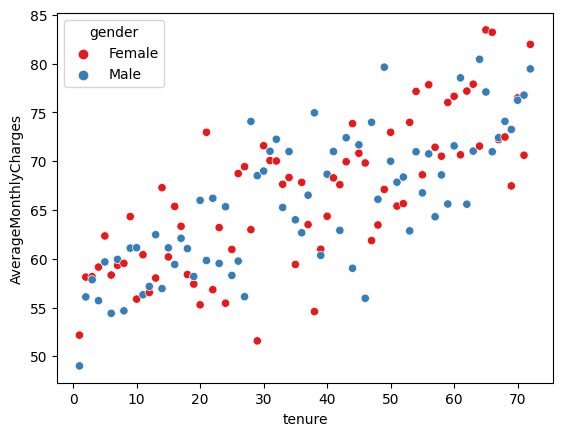

In [15]:
ave_monthly_gen=data_df.groupby(['tenure', 'gender'])['MonthlyCharges'].mean().reset_index(name='AverageMonthlyCharges')
sns.scatterplot(data=ave_monthly_gen, x= 'tenure', y='AverageMonthlyCharges', hue='gender', palette = "Set1")

In [16]:
# Convert Yes and No values to 0 and 1
data_df['Churn']=data_df.Churn.map(dict(Yes=1, No=0))
#data_df['gender']=data_df.Partner.map(dict(Male=1, Female=0))
data_df['Partner']=data_df.Partner.map(dict(Yes=1, No=0))
data_df['Dependents']=data_df.Dependents.map(dict(Yes=1, No=0))
data_df['PhoneService']=data_df.PhoneService.map(dict(Yes=1, No=0))
data_df['PaperlessBilling']=data_df.PaperlessBilling.map(dict(Yes=1, No=0))

In [17]:
data_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [18]:
data_df.dtypes

gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

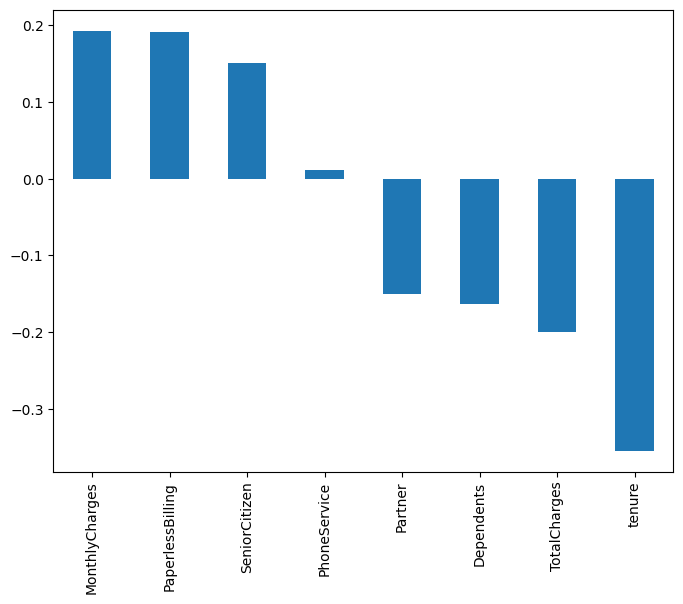

In [19]:
# check correlation between the target and the features
conti_df= data_df.select_dtypes(exclude=[object])

corr_with_tot_count = conti_df.corr()["Churn"].sort_values(ascending=False)

plt.figure(figsize=(8,6))
corr_with_tot_count.drop("Churn").plot.bar()
plt.show()

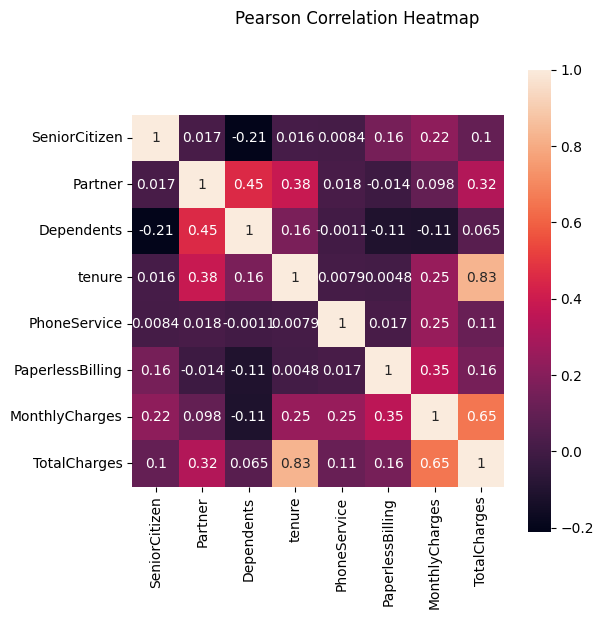

In [20]:
# check for correlation among the features

#pd.set_option('precision',2)
plt.figure(figsize=(6,6))

sns.heatmap(conti_df.drop(['Churn'],axis=1).corr(), square=True, annot=True,)
plt.suptitle("Pearson Correlation Heatmap")
plt.show()

In [21]:
# create correlation matrix
corr_matrix = conti_df.drop(['Churn'],axis=1).corr().abs()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# select one feature from the highly correlated features, threshold 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

print(to_drop)

['TotalCharges']


In [22]:
df=data_df.drop(['TotalCharges', 'PhoneService'],axis=1)
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,1,0,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,0
1,Male,0,0,0,34,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,0
2,Male,0,0,0,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,1


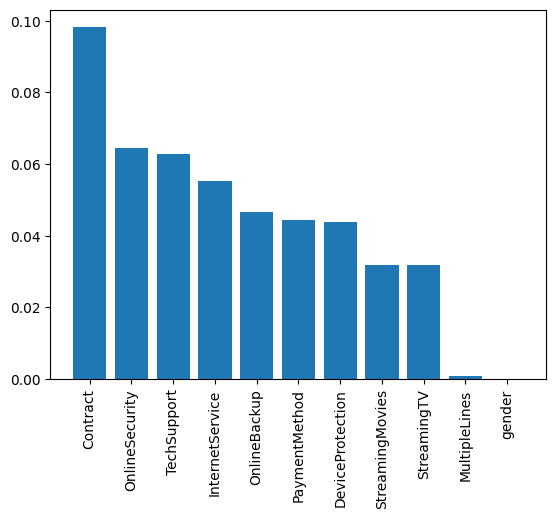

In [23]:
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, df.Churn)

# select categorial variables excluding the customerID  and Churn
cat_vars = df.select_dtypes(include=object)

# compute the mutual information score between each categorical variable and the target
feature_importance_df = cat_vars.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
plt.bar(feature_importance_df.index, height = feature_importance_df.values)
plt.xticks(rotation=90)
plt.show()

In [24]:
print(feature_importance_df)
todrop = feature_importance_df[feature_importance_df < 0.06]
todrop.index.values

Contract            0.098182
OnlineSecurity      0.064528
TechSupport         0.062873
InternetService     0.055394
OnlineBackup        0.046659
PaymentMethod       0.044423
DeviceProtection    0.043784
StreamingMovies     0.031918
StreamingTV         0.031803
MultipleLines       0.000798
gender              0.000037
dtype: float64


array(['InternetService', 'OnlineBackup', 'PaymentMethod',
       'DeviceProtection', 'StreamingMovies', 'StreamingTV',
       'MultipleLines', 'gender'], dtype=object)

In [25]:
selected_features=df.drop(todrop.index.values,axis=1)
selected_features.head(3)

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,0,1,0,1,No,No,Month-to-month,1,29.85,0
1,0,0,0,34,Yes,No,One year,0,56.95,0
2,0,0,0,2,Yes,No,Month-to-month,1,53.85,1


In [26]:
selected_features.shape

(7032, 10)

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def cal_VIF(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] =  X.columns
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))] 
    return vif_data

# convert all the categorical data to numerical applying one hot encoding
input_df = pd.get_dummies(selected_features.drop(['Churn'],axis=1), dtype=float, drop_first = True)
cal_VIF(input_df)

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,SeniorCitizen,1.359600
1,Partner,2.817676
2,Dependents,1.933504
3,tenure,6.622425
4,PaperlessBilling,2.811289
5,MonthlyCharges,5.738448
6,OnlineSecurity_No internet service,inf
7,OnlineSecurity_Yes,1.867563
8,TechSupport_No internet service,inf
9,TechSupport_Yes,1.979325


In [28]:
input_df_new = pd.get_dummies(selected_features.drop(['Churn', 'OnlineSecurity', 'TechSupport'],axis=1), dtype=float, drop_first = True)
cal_VIF(input_df_new)

,feature,VIF
0,SeniorCitizen,1.338181
1,Partner,2.808229
2,Dependents,1.875025
3,tenure,6.506892
4,PaperlessBilling,2.729916
5,MonthlyCharges,4.830691
6,Contract_One year,1.803766
7,Contract_Two year,2.903879


In [29]:
all_features_df = pd.get_dummies(selected_features[['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling','MonthlyCharges', 'Contract','tenure', 'Churn']],dtype=int, drop_first=True)
X = all_features_df.drop(['Churn'],axis=1)
y = all_features_df['Churn']

In [30]:
X.head(3)

,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,tenure,Contract_One year,Contract_Two year
0,0,1,0,1,29.85,1,0,0
1,0,0,0,0,56.95,34,1,0
2,0,0,0,1,53.85,2,0,0


### Scaling the data

In [31]:

scaler = StandardScaler()
# transform data
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns= X.columns)
X_scaled

,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,tenure,Contract_One year,Contract_Two year
0,-0.440327,1.035617,-0.652305,0.828939,-1.161694,-1.280248,-0.514537,-0.561364
1,-0.440327,-0.965608,-0.652305,-1.206361,-0.260878,0.064303,1.943495,-0.561364
2,-0.440327,-0.965608,-0.652305,0.828939,-0.363923,-1.239504,-0.514537,-0.561364
3,-0.440327,-0.965608,-0.652305,-1.206361,-0.747850,0.512486,1.943495,-0.561364
4,-0.440327,-0.965608,-0.652305,0.828939,0.196178,-1.239504,-0.514537,-0.561364
...,...,...,...,...,...,...,...,...
7027,-0.440327,1.035617,1.533025,0.828939,0.664868,-0.343137,1.943495,-0.561364
7028,-0.440327,1.035617,1.533025,0.828939,1.276493,1.612573,1.943495,-0.561364
7029,-0.440327,1.035617,1.533025,0.828939,-1.170004,-0.872808,-0.514537,-0.561364
7030,2.271039,1.035617,-0.652305,0.828939,0.319168,-1.158016,-0.514537,-0.561364


### Train/ Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y, test_size=0.2, random_state=33)

print(f'Percentage of churn in train: {round(100 * (y_train[y_train == 1].shape[0] / len(y_train)),2)} %')
print(f'Percentage of churn in test: {round(100 * (y_test[y_test == 1].shape[0] / len(y_test)),2)} %')

Percentage of churn in train: 26.58 %
Percentage of churn in test: 26.58 %


## Logistic Regression

In [33]:
model_lr = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

In [34]:
#model_lr.predict_proba(X_test)

In [35]:
def model_performance(y_test,y_pred):
    
    # calculate the accruacy of the model
    print("Accuracy score of the model", accuracy_score(y_test,y_pred))
    print("Classification report \n")
    print(classification_report(y_test,y_pred))
    
    fig = plt.figure(figsize = (4,4))
    ax = fig.gca()
    cnf_matrix_log = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="Reds" , fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix Logistic Regression\n', y=1.1)
    

Accuracy score of the model 0.8081023454157783
Classification report 

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1033
           1       0.68      0.53      0.59       374

    accuracy                           0.81      1407
   macro avg       0.76      0.72      0.73      1407
weighted avg       0.80      0.81      0.80      1407



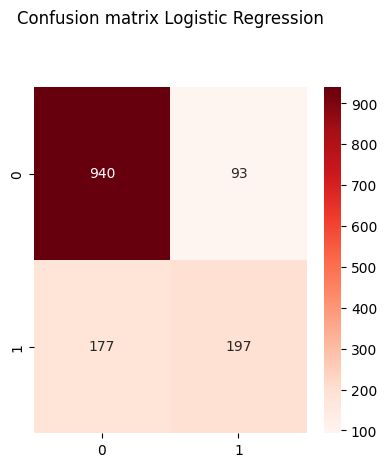

In [36]:
model_performance(y_test,y_pred)

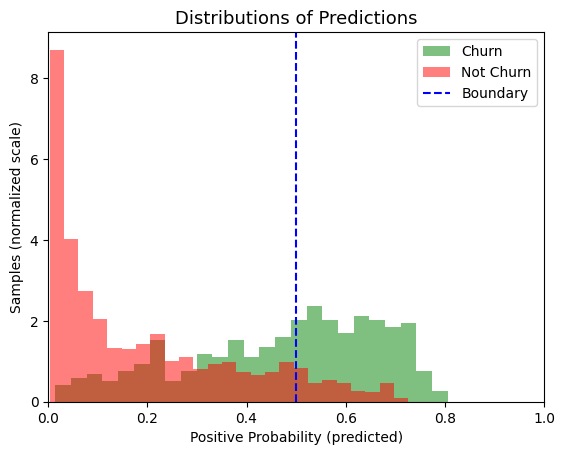

In [37]:
    labels=['Churn','Not Churn']
    p = model_lr.predict_proba(X_test)
    if len(model_lr.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model_lr.classes_[1] == 1:
        pos_p = p[:,1]
    elif model_lr.classes_[0] == 1:
        pos_p = p[:,0]
    
    prob_df = pd.DataFrame({'probPos':pos_p, 'target': y_test})

    plt.hist(prob_df[prob_df.target==1].probPos, density=True, bins=25,alpha=.5, color='green',  label=labels[0])
    plt.hist(prob_df[prob_df.target==0].probPos, density=True, bins=25,alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=13)
    plt.xlabel('Positive Probability (predicted)', size=10)
    plt.ylabel('Samples (normalized scale)', size=10)
    plt.legend(loc="upper right")

In [38]:
cv_results = cross_validate(model_lr, X_train, y_train, cv=5)
scores = cv_results["test_score"]
print("The mean cross-validation accuracy for Logistic Regression is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}")

The mean cross-validation accuracy for Logistic Regression is: 0.784 ± 0.012


In [39]:
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}
logreg_cv=GridSearchCV(model_lr,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.7852401661156868


## Random Forests

In [40]:
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50,max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

Accuracy score of the model 0.7945984363894811
Classification report 

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1033
           1       0.68      0.43      0.53       374

    accuracy                           0.79      1407
   macro avg       0.75      0.68      0.70      1407
weighted avg       0.78      0.79      0.78      1407



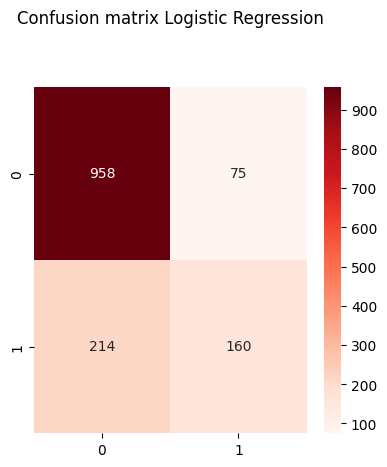

In [41]:
model_performance(y_test,prediction_test)

In [42]:
cv_results = cross_validate(model_rf, X_train, y_train, cv=5)
scores = cv_results["test_score"]
print(
    "The mean cross-validation accuracy for Random Forests Model is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation accuracy for Random Forests Model is: 0.795 ± 0.015


## Survival Analysis

In [43]:
# !pip install pysurvival # throes an error during installation 
#! pip install lifelines
#!pip install lifetimes

In [44]:
! pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 7.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=9cbe58d0201ea7c5baf8f47f23916d74aaffecb57ee3be55518f402c1a5bdc38
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [45]:
from lifelines import KaplanMeierFitter


In [46]:
input_data = df.copy()
input_data.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,1,0,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,0
1,Male,0,0,0,34,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,0
2,Male,0,0,0,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,1


<Axes: xlabel='timeline'>

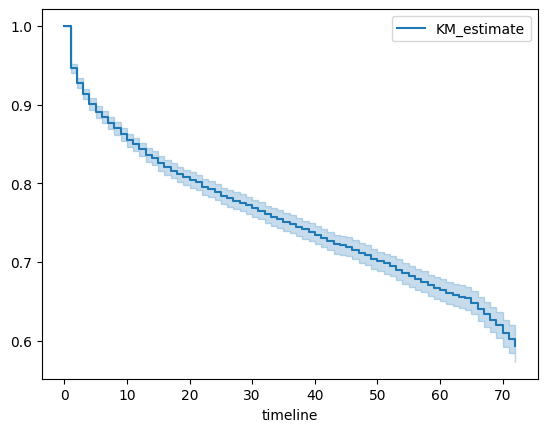

In [47]:
T = input_data['tenure']
E = input_data['Churn']

kmf = KaplanMeierFitter()
kmf.fit(T, E)

kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function()

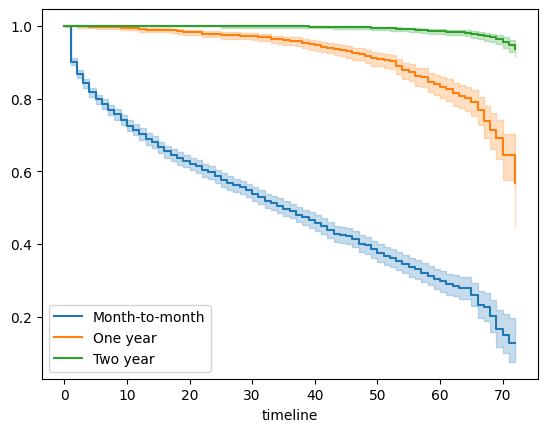

In [48]:
ax = plt.subplot(111)

for name, grouped_df in input_data.groupby('Contract'):
    kmf.fit(grouped_df["tenure"], grouped_df["Churn"], label=name)
    kmf.plot_survival_function(ax=ax)

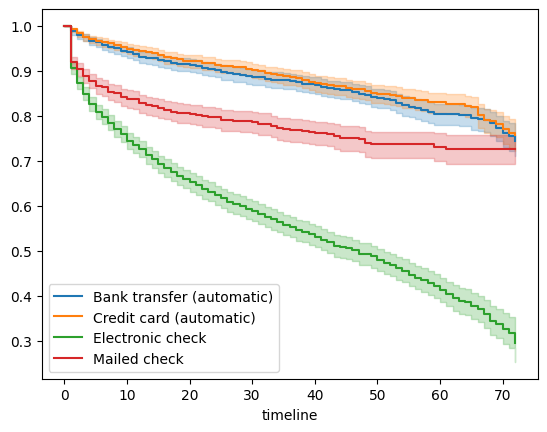

In [49]:
ax = plt.subplot(111)

for name, grouped_df in input_data.groupby('PaymentMethod'):
    kmf.fit(grouped_df["tenure"], grouped_df["Churn"], label=name)
    kmf.plot_survival_function(ax=ax)

In [50]:
all_features_df.head()

,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,tenure,Churn,Contract_One year,Contract_Two year
0,0,1,0,1,29.85,1,0,0,0
1,0,0,0,0,56.95,34,0,1,0
2,0,0,0,1,53.85,2,1,0,0
3,0,0,0,0,42.30,45,0,1,0
4,0,0,0,1,70.70,2,1,0,0


In [51]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify = y, test_size=0.2, random_state=33)

In [52]:
X_tr.loc[:,'Churn'] = y_tr

In [53]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(X_tr, duration_col='tenure', event_col='Churn')

cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 5625 total observations, 4130 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 5625
number of events observed = 1495
   partial log-likelihood = -11050.91
         time fit was run = 2023-09-05 12:19:08 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
SeniorCitizen       0.03       1.03       0.06            -0.09             0.15                 0.91                 1.16
Partner            -0.60       0.55       0.06            -0.72            -0.48                 0.49                 0.62
Dependents         -0.12       0.89       0.07            -0.26             0.03                 0.77                 1.03
PaperlessBilling    0.24       1.28       0.06             0.12             0.37                 1.13                 1.44
MonthlyCharges     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Contract_One year  -2.13       0.12       0.10            -2.31            -1.94                 0.10                 0.14
Contract_Two year  -4.01       0.02       0.17            -4.35            -3.67                 0.01                 0.03

                    cmp to      z      p   -log2(p)
covariate                                          
SeniorCitizen         0.00   0.49   0.63       0.68
Partner               0.00  -9.82 <0.005      73.18
Dependents            0.00  -1.54   0.12       3.03
PaperlessBilling      0.00   3.84 <0.005      12.99
MonthlyCharges        0.00  -0.44   0.66       0.60
Contract_One year     0.00 -22.33 <0.005     364.37
Contract_Two year     0.00 -23.09 <0.005     389.58
---
Concordance = 0.82
Partial AIC = 22115.81
log-likelihood ratio test = 2254.94 on 7 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='log(HR) (95% CI)'>

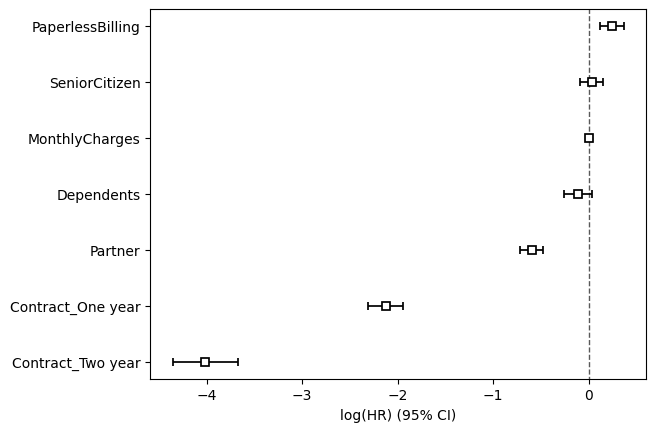

In [54]:
cph.plot()

In [55]:
cph.predict_survival_function(X_te)
cph.predict_median(X_te)
cph.predict_partial_hazard(X_te)

3466    0.055697
2751    3.083194
4049    0.321284
2601    0.053774
1440    0.288525
          ...   
73      0.055719
1151    4.950420
1329    0.049137
5447    4.889554
1389    3.451267
Length: 1407, dtype: float64

<Axes: >

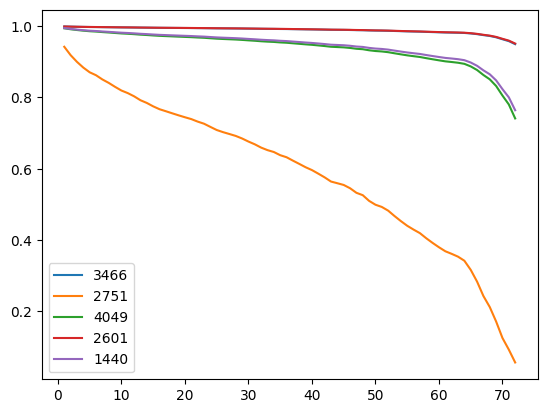

In [56]:
cph.predict_survival_function(X_te.head()).plot()